<a href="https://colab.research.google.com/github/eatuheire/Machine-Learning-/blob/Streamlit/PREDICTING_RISK_OF_CERVICAL_CANCER_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREDICTING RISK OF CERVICAL CANCER USING MACHINE LEARNING

BY Group 4 ; CLARE , ELIZABETH , LYDIA

LYDIA: Data loading, exploration, and initial preprocessing
CLARE: KNN imputation, EDA visualizations, feature importance
ELIZABETH: Model implementation, evaluation, Streamlit app
ALL: Analysis, interpretation, and presentation preparation



In [3]:
# PREDICTING RISK OF CERVICAL CANCER USING MACHINE LEARNING
# Group 4 ; CLARE , ELIZABETH , LYDIA
#LYDIA: Data loading, exploration, and initial preprocessing
#CLARE: KNN imputation, EDA visualizations, feature importance
#ELIZABETH: Model implementation, evaluation, Streamlit app
#ALL: Analysis, interpretation, and presentation preparation

In [4]:
# all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore')

# visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:
# Load and explore the dataset
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/risk_factors_cervical_cancer.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing values summary:")
# Count missing values (represented as '?')
missing_count = (df == '?').sum()
print(missing_count[missing_count > 0])

print("\nTarget variable distribution (Biopsy):")
print(df['Biopsy'].value_counts())

Mounted at /content/gdrive
Dataset Shape: (858, 36)

First few rows:
   Age Number of sexual partners First sexual intercourse Num of pregnancies  \
0   18                         4                       15                  1   
1   15                         1                       14                  1   
2   34                         1                        ?                  1   
3   52                         5                       16                  4   
4   46                         3                       21                  4   

  Smokes Smokes (years) Smokes (packs/year) Hormonal Contraceptives  \
0      0              0                   0                       0   
1      0              0                   0                       0   
2      0              0                   0                       0   
3      1             37                  37                       1   
4      0              0                   0                       1   

  Hormonal Contraceptiv

In [6]:
# Data Preprocessing and Cleaning

# Replace '?' with NaN for proper handling
df.replace('?', np.nan, inplace=True)

# Convert all columns to numeric where possible
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Data types after conversion:")
print(df.dtypes.value_counts())

# Analyze missing values after conversion
print("\nMissing values percentage:")
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage)

# Drop columns with too many missing values (>50%)
columns_to_drop = missing_percentage[missing_percentage > 50].index
print(f"\nDropping columns with >50% missing values: {list(columns_to_drop)}")
df_clean = df.drop(columns=columns_to_drop)

print(f"Shape after dropping high-missing columns: {df_clean.shape}")

Data types after conversion:
float64    26
int64      10
Name: count, dtype: int64

Missing values percentage:
STDs: Time since first diagnosis      91.724942
STDs: Time since last diagnosis       91.724942
IUD (years)                           13.636364
IUD                                   13.636364
Hormonal Contraceptives               12.587413
Hormonal Contraceptives (years)       12.587413
STDs (number)                         12.237762
STDs                                  12.237762
STDs:vulvo-perineal condylomatosis    12.237762
STDs:vaginal condylomatosis           12.237762
STDs:pelvic inflammatory disease      12.237762
STDs:syphilis                         12.237762
STDs:genital herpes                   12.237762
STDs:molluscum contagiosum            12.237762
STDs:HIV                              12.237762
STDs:AIDS                             12.237762
STDs:condylomatosis                   12.237762
STDs:cervical condylomatosis          12.237762
STDs:HPV                 

In [7]:
# Handle remaining missing values using KNN Imputation done by clare

X = df_clean.drop('Biopsy', axis=1)
y = df_clean['Biopsy']

print("Before imputation - Missing values in features:")
print(X.isnull().sum().sum())

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

print("After imputation - Missing values in features:")
print(X_imputed.isnull().sum().sum())

print(f"Final dataset shape: {X_imputed.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Class ratio: {y.value_counts(normalize=True)}")

Before imputation - Missing values in features:
2048
After imputation - Missing values in features:
0
Final dataset shape: (858, 33)
Target distribution: Biopsy
0    803
1     55
Name: count, dtype: int64
Class ratio: Biopsy
0    0.935897
1    0.064103
Name: proportion, dtype: float64


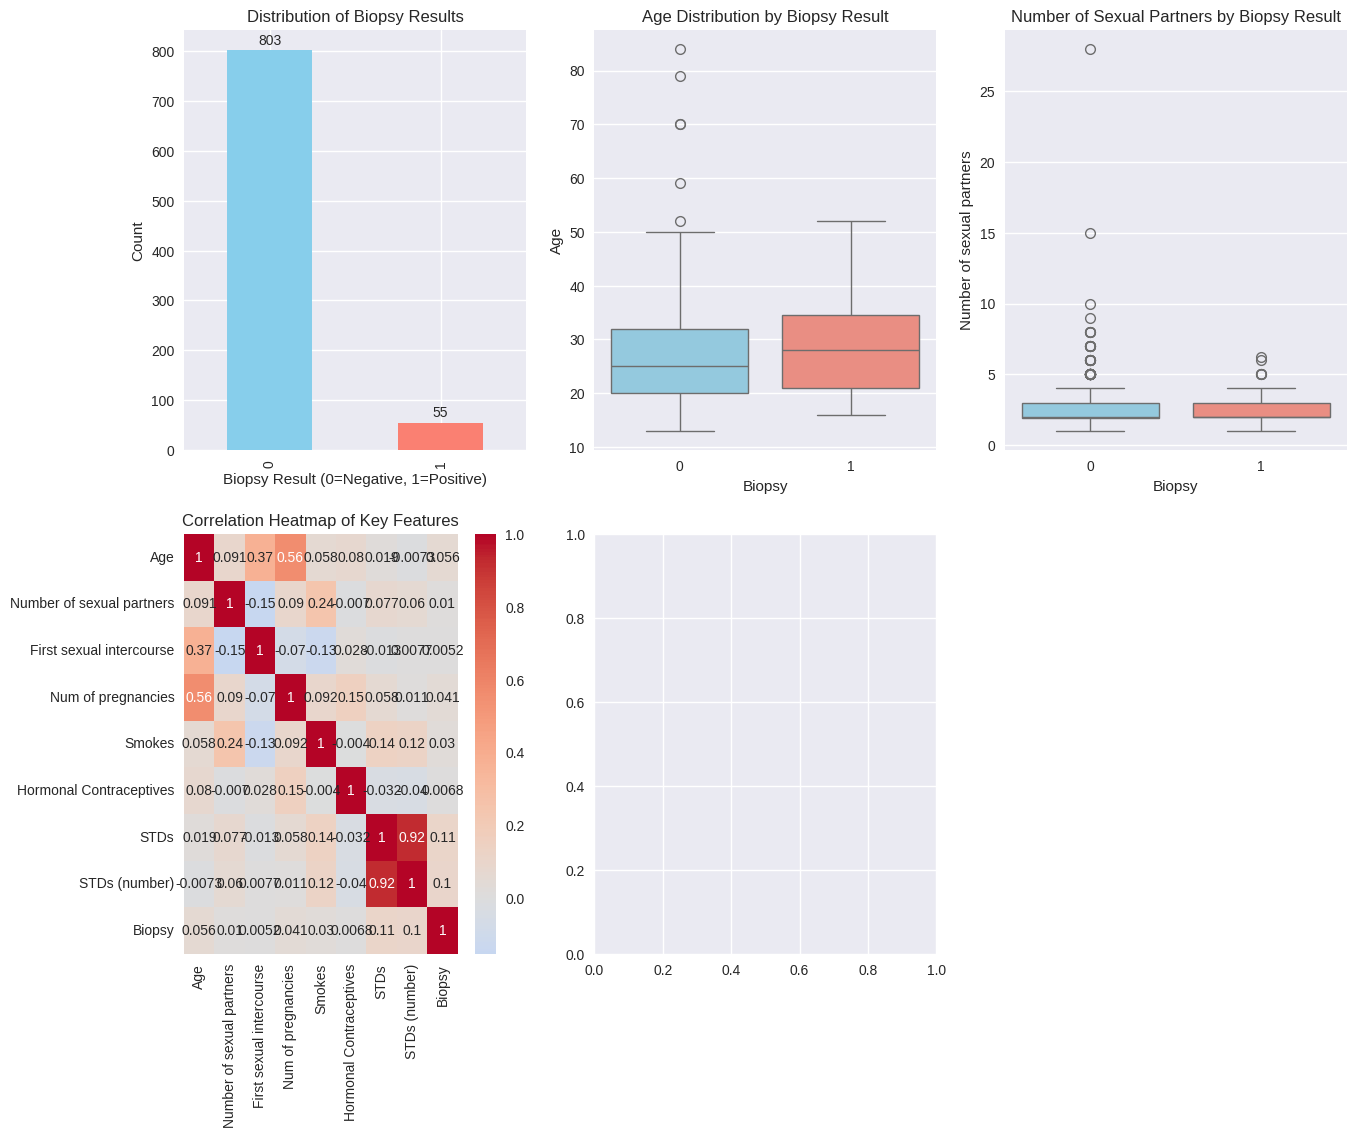

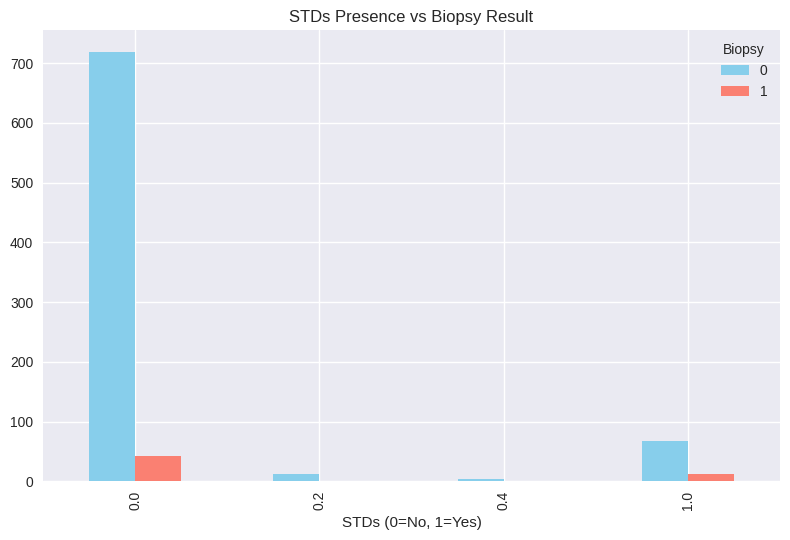

<Figure size 1000x800 with 0 Axes>

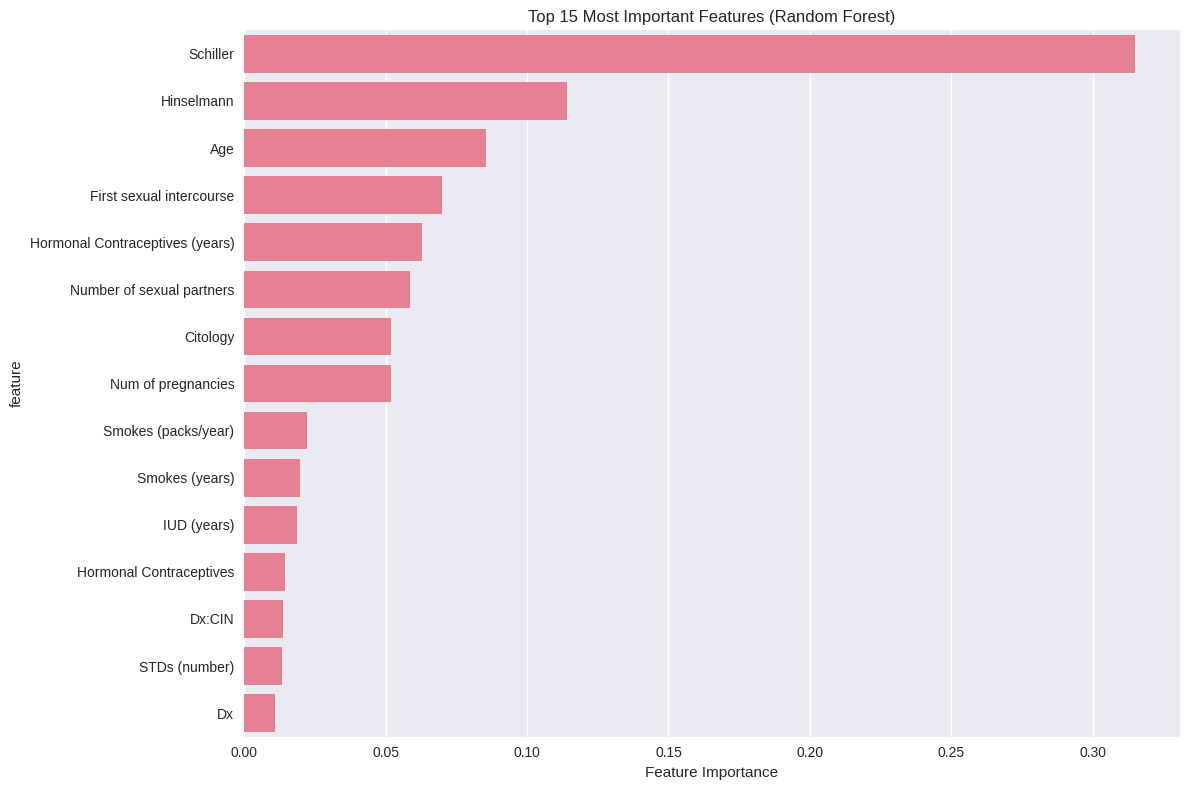

In [8]:

# summary dataframe for analysis
analysis_df = X_imputed.copy()
analysis_df['Biopsy'] = y

# 1. Target distribution
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Biopsy Results')
plt.xlabel('Biopsy Result (0=Negative, 1=Positive)')
plt.ylabel('Count')
for i, v in enumerate(y.value_counts()):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

# 2. Age distribution by biopsy result ()
plt.subplot(2, 3, 2)
sns.boxplot(x='Biopsy', y='Age', data=analysis_df, palette=['skyblue', 'salmon'])
plt.title('Age Distribution by Biopsy Result')

# 3. Number of sexual partners by biopsy result
plt.subplot(2, 3, 3)
sns.boxplot(x='Biopsy', y='Number of sexual partners', data=analysis_df, palette=['skyblue', 'salmon'])
plt.title('Number of Sexual Partners by Biopsy Result')

# 4. Correlation heatmap
plt.subplot(2, 3, 4)
# Select top features for correlation
top_features = ['Age', 'Number of sexual partners', 'First sexual intercourse',
               'Num of pregnancies', 'Smokes', 'Hormonal Contraceptives',
               'STDs', 'STDs (number)', 'Biopsy']
corr_matrix = analysis_df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Features')

# 5. STDs presence by biopsy result
plt.subplot(2, 3, 5)
std_biopsy = pd.crosstab(analysis_df['STDs'], analysis_df['Biopsy'])
std_biopsy.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('STDs Presence vs Biopsy Result')
plt.xlabel('STDs (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# 6. preview using Random Forest
plt.figure(figsize=(10, 8))
rf_preview = RandomForestClassifier(n_estimators=100, random_state=42)
rf_preview.fit(X_imputed, y)
feature_importance = pd.DataFrame({
    'feature': X_imputed.columns,
    'importance': rf_preview.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

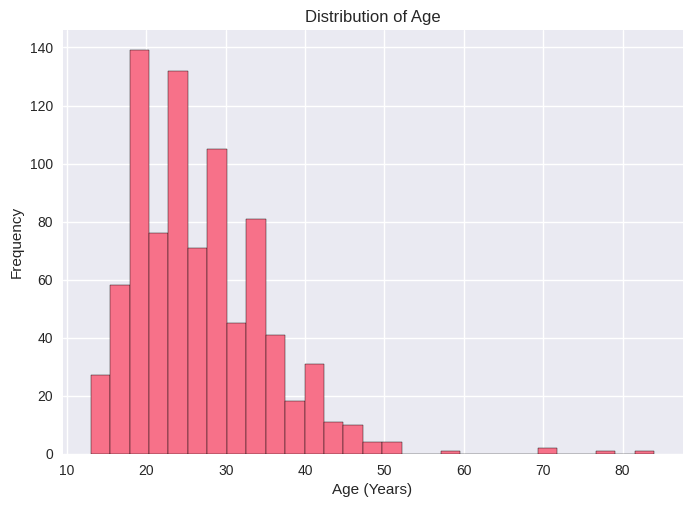

In [9]:
#univariate
#histogram showing age distribution
ax=df['Age'].hist(bins='auto' ,edgecolor = 'black')
ax.ticklabel_format(style='plain');
ax.set_title('Distribution of Age')
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Frequency')

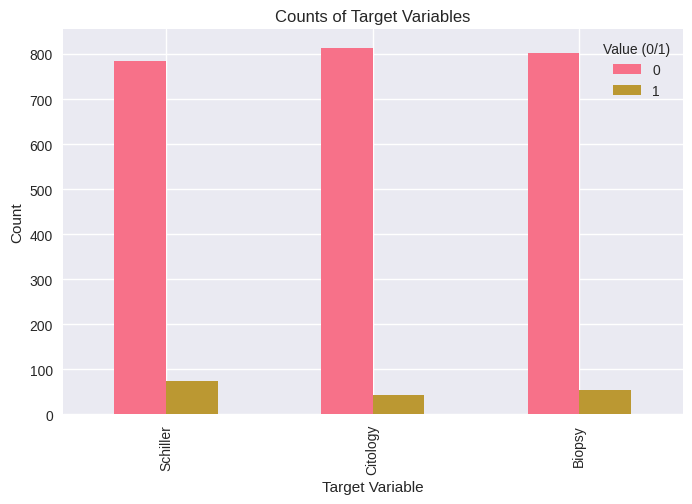

In [10]:

# Multi variate analysis
# GRouped bar chart
 #Count value frequencies for each column
cols = ["Schiller", "Citology", "Biopsy"]
counts = pd.DataFrame()
for c in cols:
    counts[c] = df[c].value_counts()
# Transpose so columns become groups
counts = counts.T
# Plot grouped bar chart
counts.plot(kind="bar", figsize=(8,5))
plt.title("Counts of Target Variables")
plt.xlabel("Target Variable")
plt.ylabel("Count")
plt.legend(title="Value (0/1)")
plt.show()

In [11]:

# Prepare data for modeling
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_imputed.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_imputed.columns)

Training set size: (686, 33)
Test set size: (172, 33)
Training set class distribution:
Biopsy
0    642
1     44
Name: count, dtype: int64
Test set class distribution:
Biopsy
0    161
1     11
Name: count, dtype: int64


In [12]:

# Model Training and Evaluation
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train model
    if name in ['RandomForestClassifier', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Random Forest Results:
Accuracy: 0.9593
Precision: 0.7500
Recall: 0.5455
F1-Score: 0.6316
AUC-ROC: 0.9421

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       161
           1       0.75      0.55      0.63        11

    accuracy                           0.96       172
   macro avg       0.86      0.77      0.81       172
weighted avg       0.96      0.96      0.96       172


Training SVM...
SVM Results:
Accuracy: 0.9535
Precision: 0.7143
Recall: 0.4545
F1-Score: 0.5556
AUC-ROC: 0.9616

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.71      0.45      0.56        11

    accuracy                           0.95       172
   macro avg       0.84      0.72      0.77       172
weighted avg       0.95      0.95      0.95       172


Training XGBoost...
XGBoo

In [13]:
#neural network
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("\n==================================================")
print("Training MLPClassifier (Neural Network)...")

# Initialize MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Two hidden layers with 100 and 50 neurons
    max_iter=1000, # Increased iterations for convergence
    random_state=42,
    activation='relu', # Rectified Linear Unit activation function
    solver='adam', # optimizer
    learning_rate_init=0.001,
    alpha=0.0001, # L2 penalty (regularization term) parameter
    verbose=True # To see training progress
)

# Train the MLP model on the scaled training data
mlp_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_pred_proba_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_roc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)

# Store results for comparison
results['MLP (Neural Network)'] = {
    'model': mlp_model,
    'accuracy': accuracy_mlp,
    'precision': precision_mlp,
    'recall': recall_mlp,
    'f1': f1_mlp,
    'auc_roc': auc_roc_mlp,
    'predictions': y_pred_mlp,
    'probabilities': y_pred_proba_mlp
}

print("\nMLP (Neural Network) Results:")
print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-Score: {f1_mlp:.4f}")
print(f"AUC-ROC: {auc_roc_mlp:.4f}")

# Classification report
print(f"\nClassification Report for MLP (Neural Network):")
print(classification_report(y_test, y_pred_mlp))



Training MLPClassifier (Neural Network)...
Iteration 1, loss = 0.64959040
Iteration 2, loss = 0.53401351
Iteration 3, loss = 0.44666557
Iteration 4, loss = 0.37902155
Iteration 5, loss = 0.31991957
Iteration 6, loss = 0.26838601
Iteration 7, loss = 0.22570678
Iteration 8, loss = 0.19057784
Iteration 9, loss = 0.16541000
Iteration 10, loss = 0.14573467
Iteration 11, loss = 0.13054130
Iteration 12, loss = 0.11932562
Iteration 13, loss = 0.11076198
Iteration 14, loss = 0.10323923
Iteration 15, loss = 0.09773258
Iteration 16, loss = 0.09315842
Iteration 17, loss = 0.08948067
Iteration 18, loss = 0.08644773
Iteration 19, loss = 0.08352452
Iteration 20, loss = 0.08089567
Iteration 21, loss = 0.07850882
Iteration 22, loss = 0.07631918
Iteration 23, loss = 0.07440197
Iteration 24, loss = 0.07255119
Iteration 25, loss = 0.07071913
Iteration 26, loss = 0.06906486
Iteration 27, loss = 0.06749081
Iteration 28, loss = 0.06590638
Iteration 29, loss = 0.06462344
Iteration 30, loss = 0.06300773
Itera

Model Performance Comparison:
                      Accuracy  Precision  Recall  F1-Score  AUC-ROC
Random Forest           0.9593     0.7500  0.5455    0.6316   0.9421
SVM                     0.9535     0.7143  0.4545    0.5556   0.9616
XGBoost                 0.9593     0.7500  0.5455    0.6316   0.9650
MLP (Neural Network)    0.9419     0.5714  0.3636    0.4444   0.9441


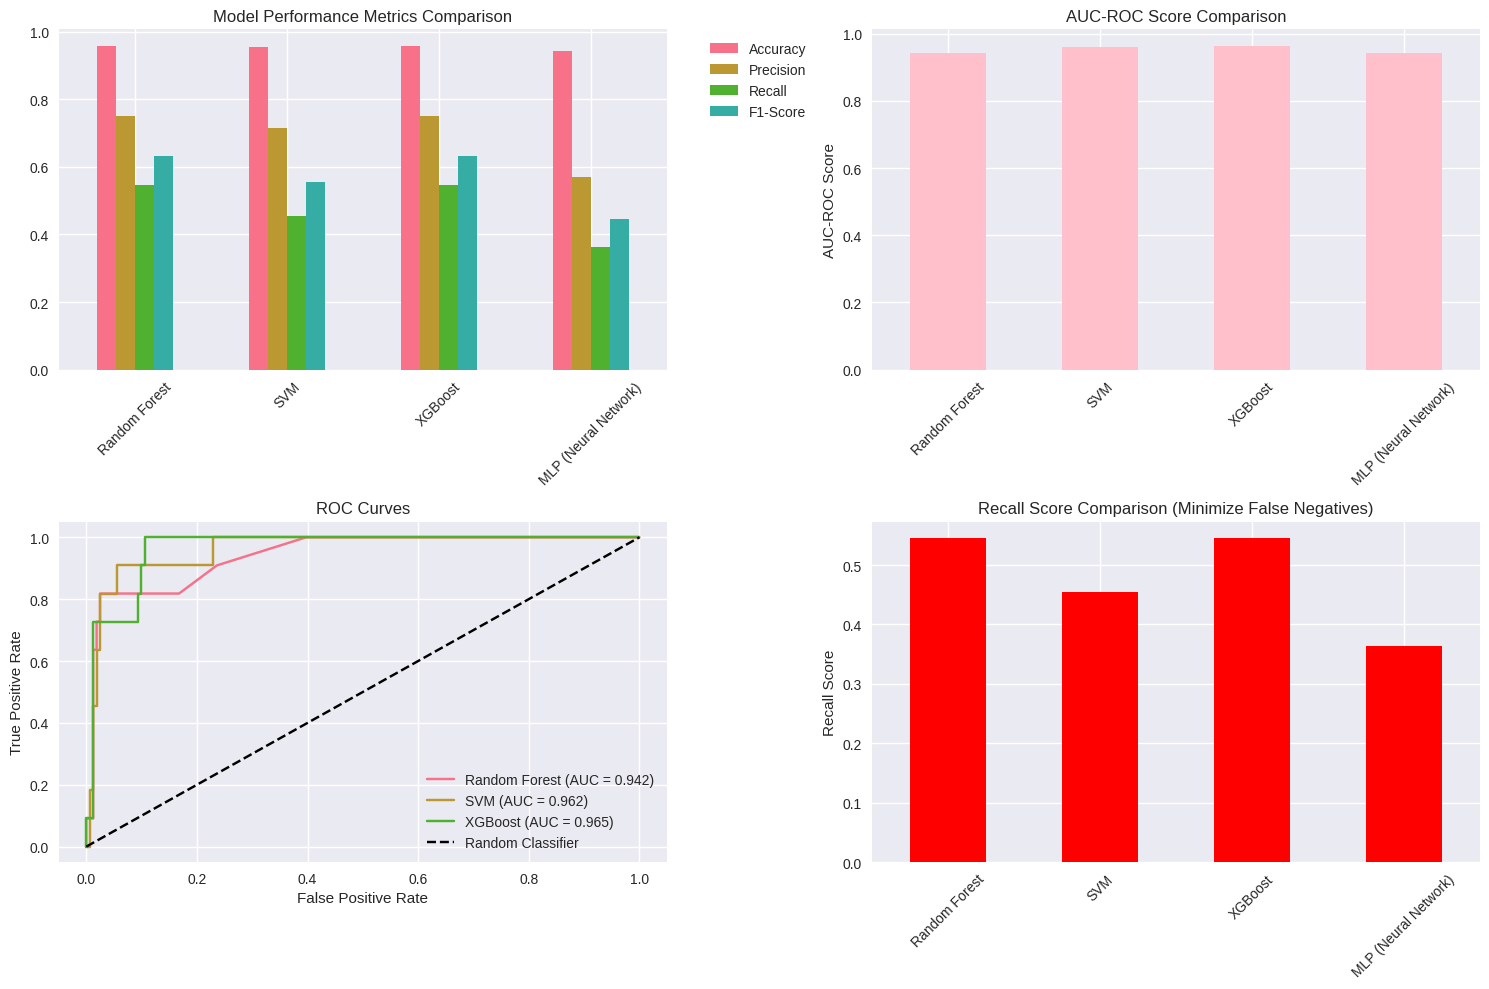

In [14]:
# Model Comparison and Visualization

# Comparison DataFrame
results_df = pd.DataFrame({
    name: [
        results[name]['accuracy'],
        results[name]['precision'],
        results[name]['recall'],
        results[name]['f1'],
        results[name]['auc_roc']
    ] for name in results.keys()
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']).T

print("Model Performance Comparison:")
print(results_df.round(4))

# Plot performance comparison
plt.figure(figsize=(15, 10))

# Metrics comparison
plt.subplot(2, 2, 1)
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Metrics Comparison')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# AUC-ROC comparison
plt.subplot(2, 2, 2)
results_df['AUC-ROC'].plot(kind='bar', color='pink', ax=plt.gca())
plt.title('AUC-ROC Score Comparison')
plt.xticks(rotation=45)
plt.ylabel('AUC-ROC Score')

# ROC Curves
plt.subplot(2, 2, 3)
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc_roc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Focus on Recall (most important metric for medical diagnosis)
plt.subplot(2, 2, 4)
results_df['Recall'].plot(kind='bar', color='red', ax=plt.gca())
plt.title('Recall Score Comparison (Minimize False Negatives)')
plt.xticks(rotation=45)
plt.ylabel('Recall Score')

plt.tight_layout()
plt.show()

In [15]:
#Cross-Validation for more robust evaluation
print("Performing Cross-Validation...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\nCross-validating {name}...")

    if name in ['Logistic Regression', 'SVM']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train

    # Cross-validation scores
    cv_accuracy = cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(model, X_cv, y_train, cv=cv, scoring='precision')
    cv_recall = cross_val_score(model, X_cv, y_train, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(model, X_cv, y_train, cv=cv, scoring='f1')
    cv_auc = cross_val_score(model, X_cv, y_train, cv=cv, scoring='roc_auc')

    cv_results[name] = {
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV Recall': cv_recall.mean(),
        'CV F1': cv_f1.mean(),
        'CV AUC': cv_auc.mean()
    }

    print(f"CV Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")
    print(f"CV Recall: {cv_recall.mean():.4f} (+/- {cv_recall.std() * 2:.4f})")

# CV comparison
cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results:")
print(cv_df.round(4))

Performing Cross-Validation...

Cross-validating Random Forest...
CV Accuracy: 0.9490 (+/- 0.0183)
CV Recall: 0.4556 (+/- 0.3745)

Cross-validating SVM...
CV Accuracy: 0.9373 (+/- 0.0215)
CV Recall: 0.2278 (+/- 0.1423)

Cross-validating XGBoost...
CV Accuracy: 0.9563 (+/- 0.0206)
CV Recall: 0.5389 (+/- 0.3055)

Cross-Validation Results:
               CV Accuracy  CV Precision  CV Recall   CV F1  CV AUC
Random Forest       0.9490        0.7234     0.4556  0.5076  0.9547
SVM                 0.9373        0.5500     0.2278  0.3163  0.9375
XGBoost             0.9563        0.7353     0.5389  0.6018  0.9472


In [16]:
import joblib
# Hyperparameter Tuning for the best model

# tune the best performing model
print("Performing Hyperparameter Tuning...")

# Let's assume Random Forest or XGBoost performed best
best_model_name = max(results.keys(), key=lambda x: results[x]['recall'])
print(f"Tuning the best model: {best_model_name}")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestClassifier(random_state=42)

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    model = XGBClassifier(random_state=42, eval_metric='logloss')

elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    model = LogisticRegression(random_state=42, max_iter=1000)

else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'linear']
    }
    model = SVC(random_state=42, probability=True)

# Perform grid search with recall as scoring metric
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring='recall',
    n_jobs=-1, verbose=1
)

if best_model_name in ['Logistic Regression', 'SVM']:
    grid_search.fit(X_train_scaled, y_train)
else:
    grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_model = grid_search.best_estimator_

# Save the best model and scaler
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Best model and scaler saved as 'best_model.pkl' and 'scaler.pkl'")

if best_model_name in ['Logistic Regression', 'SVM']:
    y_pred_final = best_model.predict(X_test_scaled)
    y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_final = best_model.predict(X_test)
    y_pred_proba_final = best_model.predict_proba(X_test)[:, 1]

# Evaluate final tuned model
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_auc = roc_auc_score(y_test, y_pred_proba_final)

print(f"\nFinal Tuned Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"AUC-ROC: {final_auc:.4f}")

Performing Hyperparameter Tuning...
Tuning the best model: Random Forest
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation recall: 0.6361
Best model and scaler saved as 'best_model.pkl' and 'scaler.pkl'

Final Tuned Model Performance:
Accuracy: 0.9535
Precision: 0.7143
Recall: 0.4545
F1-Score: 0.5556
AUC-ROC: 0.9644


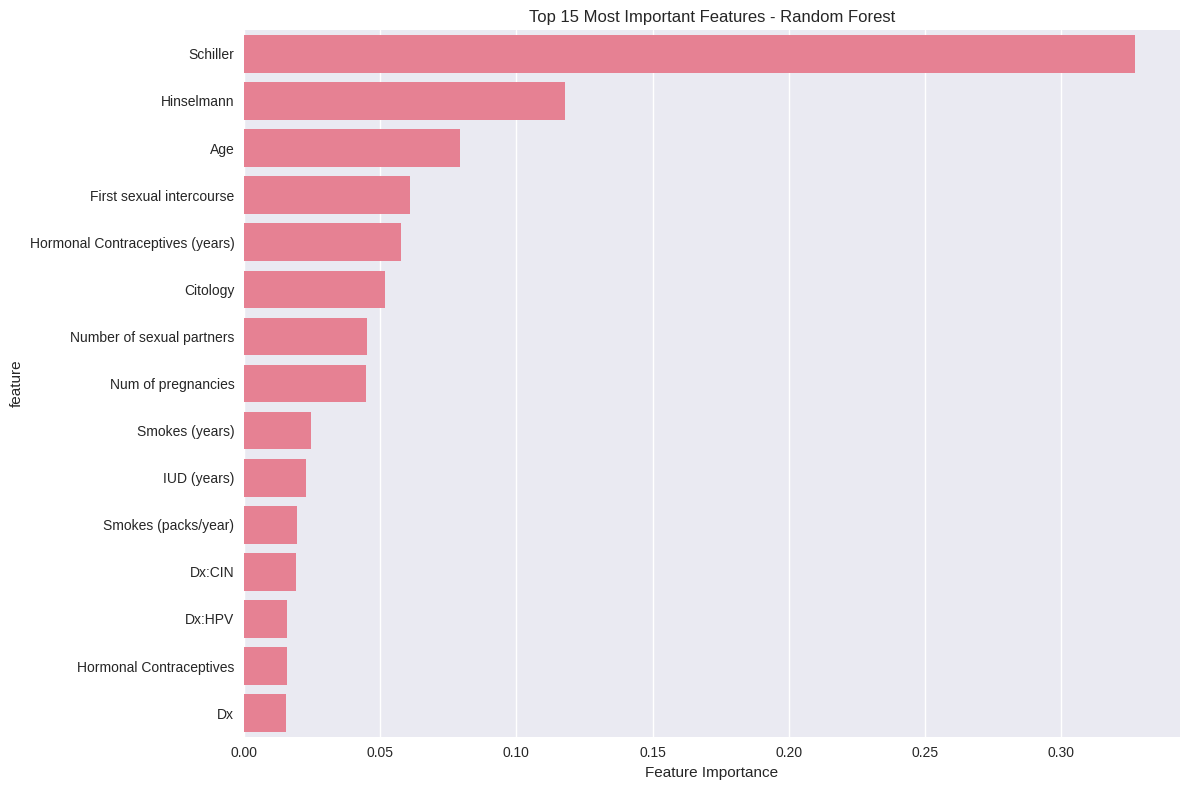

Top 10 Most Important Features:
                            feature  importance
31                         Schiller    0.327340
30                       Hinselmann    0.117754
0                               Age    0.079363
2          First sexual intercourse    0.060858
8   Hormonal Contraceptives (years)    0.057516
32                         Citology    0.051778
1         Number of sexual partners    0.045006
3                Num of pregnancies    0.044799
5                    Smokes (years)    0.024450
10                      IUD (years)    0.022754


In [17]:
# Feature Importance Analysis and Model Interpretation
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))

    feature_importance = pd.DataFrame({
        'feature': X_imputed.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 15 features
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title(f'Top 15 Most Important Features - {best_model_name}')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

elif best_model_name == 'Logistic Regression':
    # For logistic regression, we can look at coefficients
    plt.figure(figsize=(12, 8))

    coefficients = pd.DataFrame({
        'feature': X_imputed.columns,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', key=abs, ascending=False)

    # Plot top 10 coefficients
    sns.barplot(data=coefficients.head(10), x='coefficient', y='feature')
    plt.title(f'Top 15 Most Influential Features - {best_model_name}')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Influential Features:")
    print(coefficients.head(10))

In [18]:
# deployment-ready prediction

def predict_cervical_cancer_risk(patient_data, model=best_model, scaler=scaler, feature_names=X_imputed.columns):
    """
    Predict cervical cancer risk for a new patient

    Parameters:
    patient_data: dict or array-like containing patient features
    model: trained model
    scaler: fitted scaler
    feature_names: list of feature names

    Returns:
    dict: prediction results
    """

    # Convert to DataFrame if it's a dictionary
    if isinstance(patient_data, dict):
        patient_df = pd.DataFrame([patient_data])
        # Ensure all features are present and in correct order
        for feature in feature_names:
            if feature not in patient_df.columns:
                patient_df[feature] = 0  # or appropriate default value
        patient_df = patient_df[feature_names]
    else:
        patient_df = pd.DataFrame([patient_data], columns=feature_names)

    # Scale the data if needed
    if hasattr(model, 'feature_importances_'):  # Tree-based models usually don't need scaling
        prediction = model.predict(patient_df)[0]
        probability = model.predict_proba(patient_df)[0, 1]
    else:
        patient_scaled = scaler.transform(patient_df)
        # Convert scaled array back to DataFrame with feature names to avoid UserWarning
        patient_scaled_df = pd.DataFrame(patient_scaled, columns=feature_names)
        prediction = model.predict(patient_scaled_df)[0]
        probability = model.predict_proba(patient_scaled_df)[:, 1][0]

    risk_level = "High Risk" if prediction == 1 else "Low Risk"
    confidence = probability if prediction == 1 else (1 - probability)

    return {
        'prediction': prediction,
        'probability': probability,
        'risk_level': risk_level,
        'confidence': confidence
    }

# Example usage:
print("Example Prediction:")
sample_patient = {
    'Age': 35,
    'Number of sexual partners': 3,
    'First sexual intercourse': 17,
    'Num of pregnancies': 2,
    'Smokes': 0,
    'Hormonal Contraceptives': 1,
    'IUD': 0,
    'STDs': 0,
    'STDs (number)': 0
}

# Add remaining features with default values
for feature in X_imputed.columns:
    if feature not in sample_patient:
        sample_patient[feature] = 0

prediction_result = predict_cervical_cancer_risk(sample_patient)
print(f"Prediction: {prediction_result}")

Example Prediction:
Prediction: {'prediction': np.int64(0), 'probability': np.float64(0.0016649201708669804), 'risk_level': 'Low Risk', 'confidence': np.float64(0.998335079829133)}


DEMO CODE

In [19]:
%%writefile app.py
pip install streamlit

pip install streamlit
import streamlit as st
import pickle
import numpy as np
source .venv/bin/activate

model = pickle.load(open('best_model.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))

def main():
    st.title("🩺 Cervical Cancer Risk Assessment Tool")
    st.write("A clinical decision support system for healthcare providers")

    # Patient input form
    with st.form("patient_form"):
        col1, col2 = st.columns(2)

        with col1:
            age = st.slider("Age", 15, 80, 35)
            num_partners = st.slider("Number of sexual partners", 1, 30, 3)
            first_sex = st.slider("Age at first intercourse", 10, 30, 17)

        with col2:
            pregnancies = st.slider("Number of pregnancies", 0, 15, 2)
            smokes = st.selectbox("Smokes", ["No", "Yes"])
            hormonal_contraceptives = st.selectbox("Uses hormonal contraceptives", ["No", "Yes"])

        submitted = st.form_submit_button("Assess Risk")

        if submitted:
            # Process inputs and make prediction
            features = process_inputs(age, num_partners, first_sex, pregnancies, smokes, hormonal_contraceptives)
            risk_score, confidence = predict_risk(features)

            # Display results
            if risk_score == 1:
                st.error(f"🚨 HIGH RISK: {confidence:.1%} probability")
                st.write("**Recommendation**: Schedule biopsy within 2 weeks")
            else:
                st.success(f"✅ LOW RISK: {(1-confidence):.1%} confidence")
                st.write("**Recommendation**: Routine screening schedule")

if __name__ == "__main__":
    main()

Overwriting app.py
